# Introduction to Federated Learning with Flower

Welcome to the Hands-On Session. We will investigate:

1.   Simple FedAvg with IID data
2.   Simple FedAvg with non-IID data
3.   The impact of local iterations and understand the impact of non-IID as well as client drift
4.   Other agg strategies to address the non-IIDness

The repository can be found here [https://github.com/jopasserat/federated-learning-tutorial](https://) as well as the an experiment introducing differential privacy.



## Part 0: Prerequisites

Firstly we need to install all the dependencies as well as import the required packages. 
Please turn on GPU under Google Colab: 

`Runtime > Change runtime type > Hardware accelerator: GPU > Save`

### Installing dependencies

We will first install all the necessary packages for this workshop

In [ ]:
!pip install flwr["simulation"]==0.18.0 torch torchvision matplotlib
!pip install medmnist
!pip install -U ray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DEFAULT_ROOT = '/content'

import shutil
from pathlib import Path
import numpy as np
import ray
from tqdm import tqdm

from typing import Dict, Tuple, Callable, OrderedDict, Optional

import flwr as fl
from flwr.common.typing import Scalar
from flwr.dataset.utils.common import create_lda_partitions

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import Compose
import torch.optim as optim
import torch.utils.data as data

import medmnist
from medmnist import INFO
from medmnist import Evaluator

from collections import OrderedDict

Mounted at /content/drive


### Loading the data

Let's now load the MedMNIST v2 dataset. 

"This is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D [...]. All images are pre-processed into 28x28 (2D) [...] with the corresponding classification labels, so that no background knowledge is required for users. Covering primary data modalities in biomedical images, MedMNIST v2 is designed to perform classification on lightweight 2D [...] images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label). The resulting dataset, consisting of 708,069 2D images [...]." (https://medmnist.com/)

In [ ]:
def pathmnist_transforms() -> Compose:
    return transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize(mean=[0.5], std=[0.5])])

def get_medmnist_data_info(dataset_title: str) -> Tuple[Dataset, Dict]:
    data_flag = dataset_title
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info["python_class"])
    return DataClass, info

def get_dataset( base_path: str = DEFAULT_ROOT, dataset_title: str = "pathmnist",
                download: bool = True, split: str = "train",) -> Tuple[Dataset, Dict]:
    """Fetch centralised version of the dataset if needed."""

    # preprocessing
    data_transform = pathmnist_transforms()

    DataClass, info = get_medmnist_data_info(dataset_title)

    # load the data
    dataset = DataClass(root=base_path, split=split, transform=data_transform, 
                        download=download)

    return dataset, info

print(DEFAULT_ROOT)
trainset, info = get_dataset(split="train")
testset, _ = get_dataset(split="test")

n_classes = len(info["label"])
n_channels = info["n_channels"]

print(trainset)
print(testset)

/content
Using downloaded and verified file: /content/pathmnist.npz
Using downloaded and verified file: /content/pathmnist.npz
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /content
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a mult

Our dataset consists of 89,996 train and 7,180 test samples. Below we can have a look at some sample images.

(3, 28, 28) (1,)


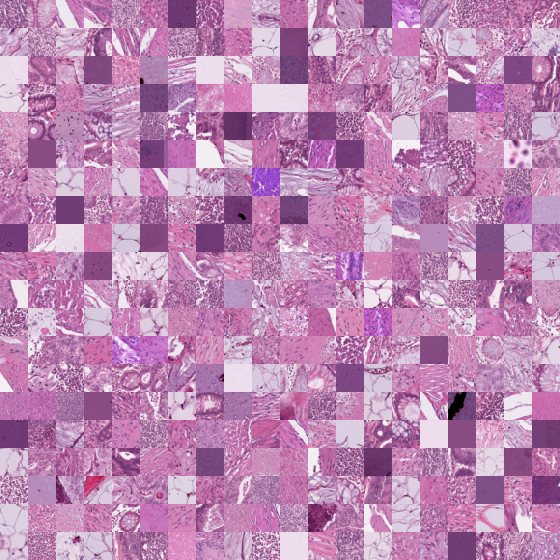

In [ ]:
x, y = trainset[0]

print(np.array(x).shape, y.shape)
trainset.montage(length=20)

## Part 1: Defining the Model



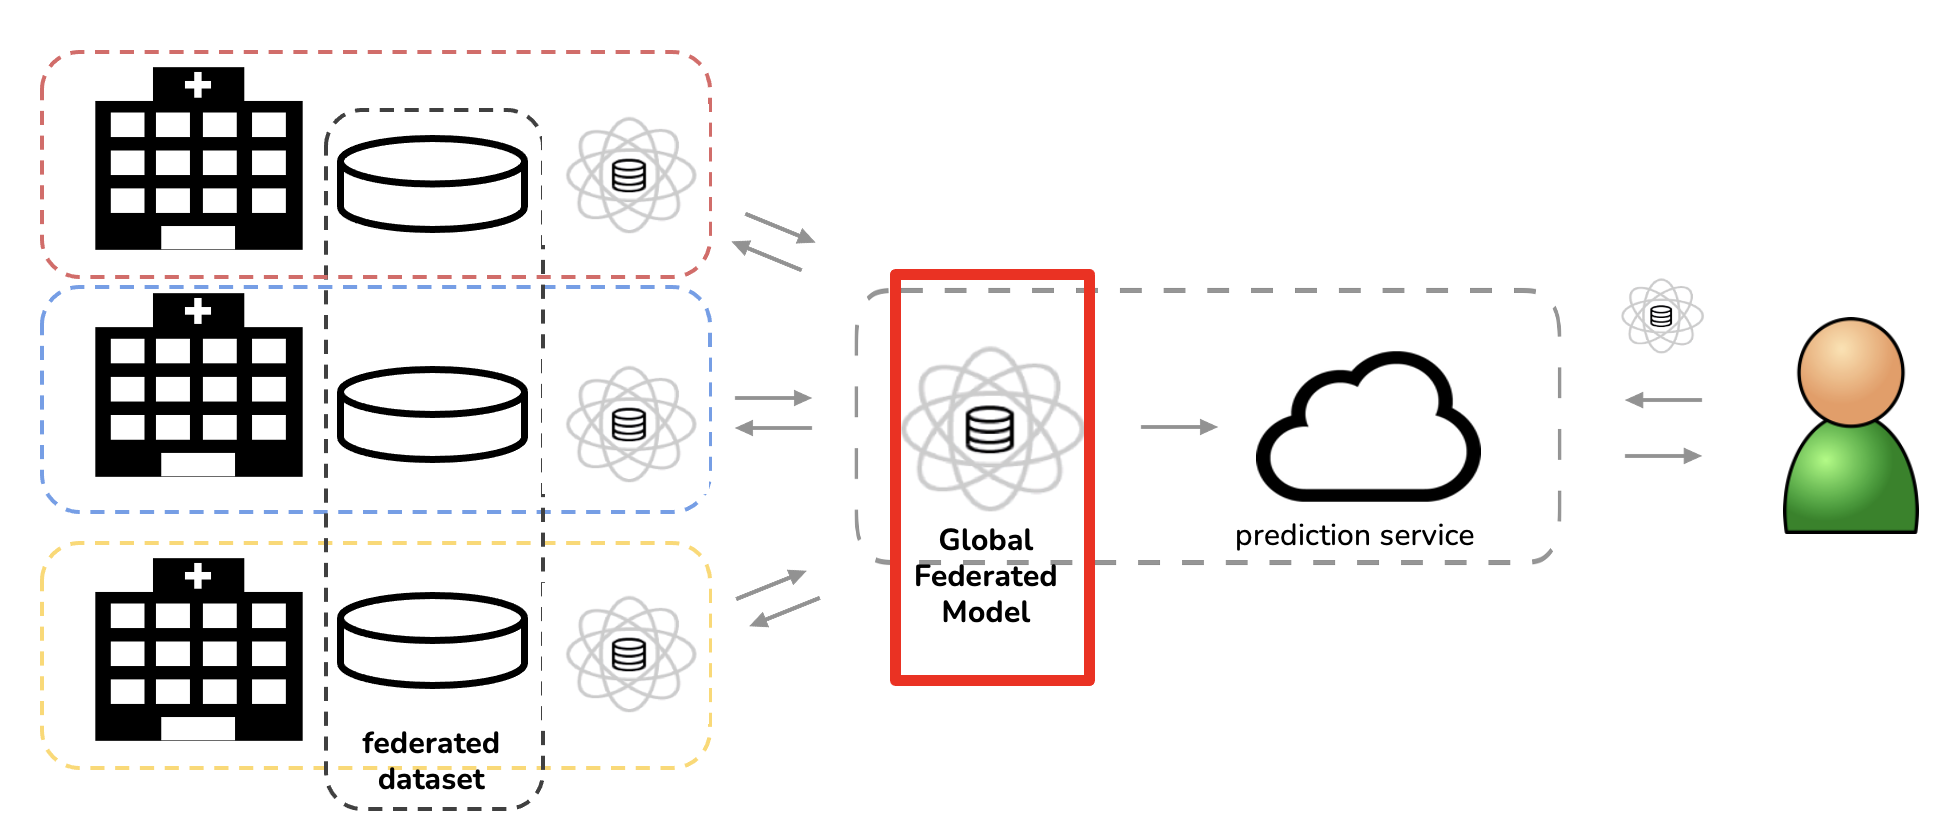

We use the simple CNN

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3), 
                                    nn.BatchNorm2d(16), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2),)

        self.layer3 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3), 
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3), 
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2),)

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 128), nn.ReLU(),
                                nn.Linear(128, 128), nn.ReLU(), 
                                nn.Linear(128, num_classes),)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

And make use of the usual training and test functions:

In [ ]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module,
          train_loader: data.DataLoader, NUM_EPOCHS: int, device: torch.device,
          ) -> None:
    """Train the network on the training set."""
    for epoch in range(NUM_EPOCHS):
        model.train()

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

def test(model: nn.Module, criterion: nn.Module, data_flag: str,
         eval_loader: data.DataLoader, split: str, device: torch.device,
         ) -> Tuple[float, float, float]:
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    loss = 0.0

    with torch.no_grad():
        for inputs, targets in eval_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            targets = targets.squeeze().long()
            loss += criterion(outputs, targets).item()

            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split, root=eval_loader.dataset.root)
        metrics = evaluator.evaluate(y_score)

        auc, acc = metrics
        print("%s  auc: %.3f  acc:%.3f" % (split, auc, acc))

        return loss, acc, auc

## Part 2: Federated Learning with Flower

### Functions to split the data

Here we defined functions that allow us to split the data and distribute them amongst clients This allows us to experiment with simple FedAVg with IID data 
same FedAvg but non-IID split.

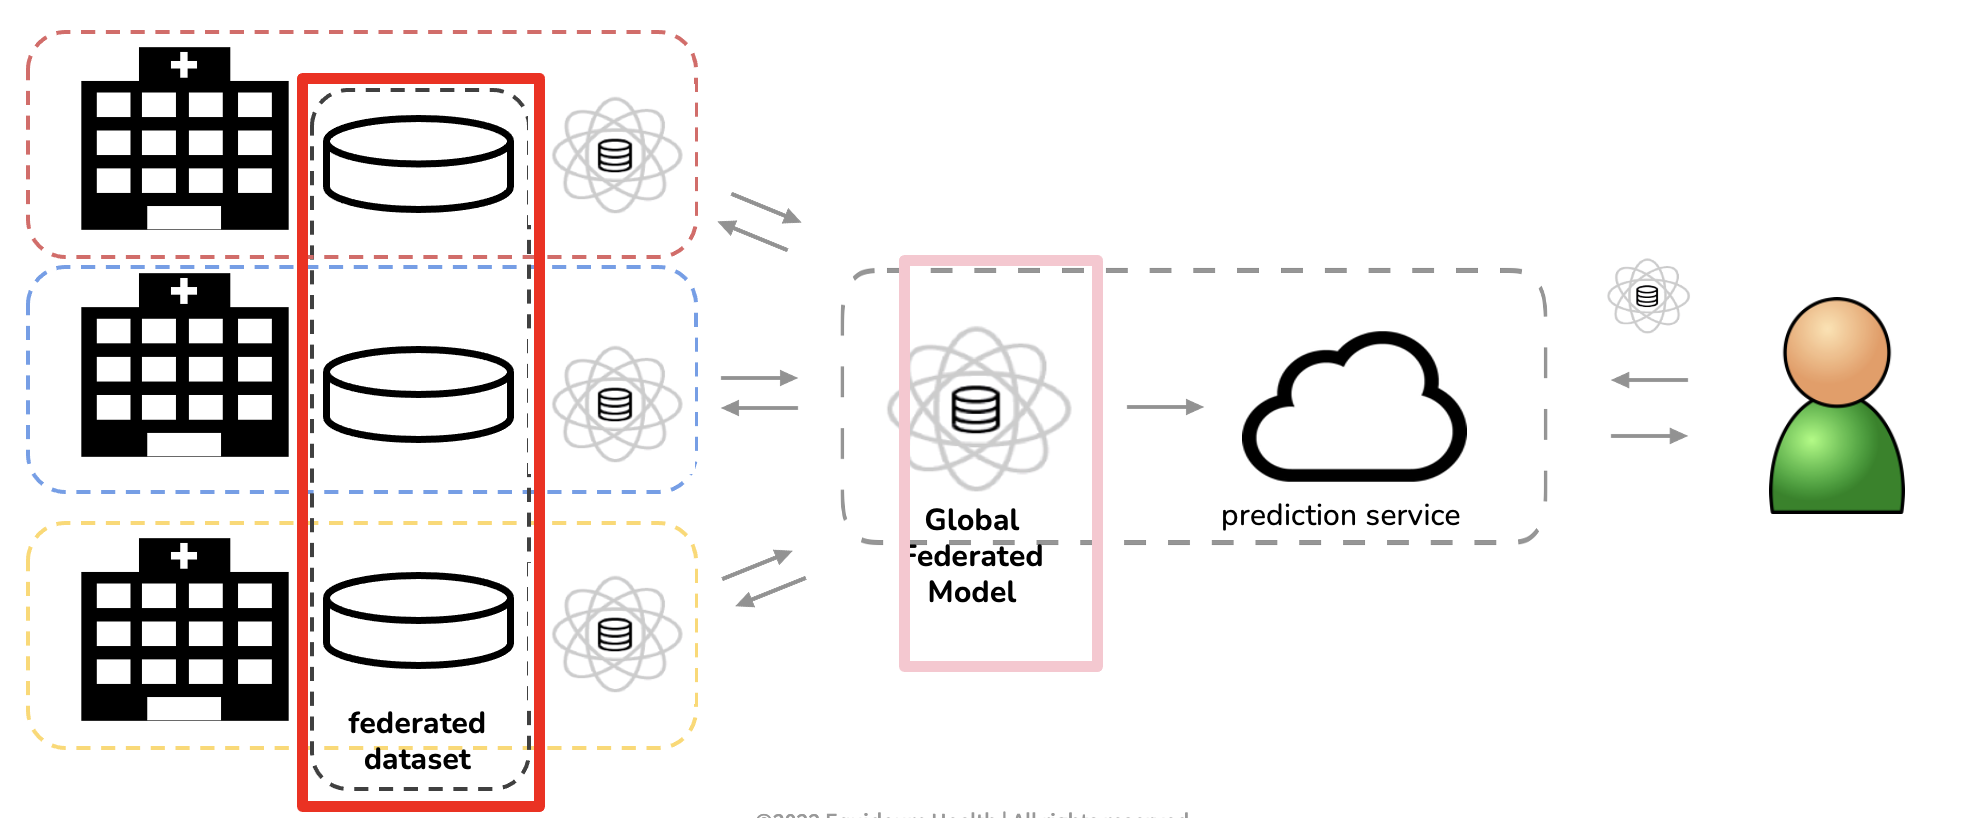

In [ ]:
def get_random_id_splits(total: int, val_ratio: float, shuffle: bool = True):
    """
    splits a list of length `total` into two following a (1-val_ratio):val_ratio 
    partitioning. By default the indices are shuffled before creating the split 
    andreturning.
    """

    if isinstance(total, int):
        indices = list(range(total))
    else:
        indices = total

    split = int(np.floor(val_ratio * len(indices)))

    if shuffle:
        np.random.shuffle(indices)
    return indices[split:], indices[:split]

The number of clients is defined by the `pool_size`.

`alpha` allows us to change the split of the data by making use of flower's dirichlet's implementation.



In [ ]:
def do_fl_partitioning(path_to_dataset, pool_size: int, alpha: float, 
                       num_classes: int, val_ratio=0.0):
    """(non-)IID partitioning of Torchvision datasets using LDA."""

    # images, labels = torch.load(path_to_dataset)
    images = path_to_dataset.imgs
    labels = path_to_dataset.labels

    idx = np.array(range(len(images)))
    dataset = [idx, labels]
    partitions, _ = create_lda_partitions(dataset, num_partitions=pool_size, 
                                          concentration=alpha, 
                                          accept_imbalanced=True)

    # Show label distribution for first partition (purely informative)
    partition_zero = partitions[0][1]
    hist, _ = np.histogram(partition_zero, bins=list(range(num_classes + 1)))
    print(f"Class histogram for 0-th partition (alpha={alpha},{num_classes} classes): {hist}")

    # now save partitioned dataset to disk
    # first delete dir containing splits (if exists), then create it
    string_alpha = "federated" + str(alpha)
    splits_dir = Path(path_to_dataset.root) / string_alpha
    if splits_dir.exists():
        shutil.rmtree(splits_dir)
    Path.mkdir(splits_dir, parents=True)

    for p in range(pool_size):

        labels = partitions[p][1]
        image_idx = partitions[p][0]
        imgs = images[image_idx]

        # create dir
        Path.mkdir(splits_dir / str(p))

        if val_ratio > 0.0:
            # split data according to val_ratio
            train_idx, val_idx = get_random_id_splits(len(labels), val_ratio)
            val_imgs = imgs[val_idx]
            val_labels = labels[val_idx]

            # remaining images for training
            imgs = imgs[train_idx]
            labels = labels[train_idx]

        with open(splits_dir / str(p) / "pathmnist.npz", "wb") as f:
            d = {"train_images": imgs, "train_labels": labels, "val_images": 
                 val_imgs, "val_labels": val_labels,}

            np.savez(f, **d)

    return splits_dir

### Experiment 1
Experiment with the alpha parameter. The files will be saved under `/content/federated$alpha`



In [ ]:
pool_size = 2
alpha = 1000

fed_dir = do_fl_partitioning(trainset,pool_size=pool_size, alpha=alpha,
                             num_classes=n_classes,val_ratio=0.1,)

Class histogram for 0-th partition (alpha=1000,9 classes): [4988 4911 5144 5217 4837 5158 4733 4989 5021]


### Dataloader

Next, we define a dataloader for the federated data environment.

In [ ]:
def get_federated_dataloader(base_path: Path, client_id: str, data_str: str, 
                             is_train: bool, batch_size: int,workers: int,
                             shuffle: bool, transforms: Callable[[], Compose],
                             ) -> DataLoader:
    """
    Generates trainset/valset object and returns appropiate dataloader.
    This is the federated version.
    """

    split = "train" if is_train else "val"

    path_to_data = base_path / client_id

    DataClass, _ = get_medmnist_data_info(data_str)

    client_dataset = DataClass(
        root=str(path_to_data), download=False, split=split, transform=transforms
    )

    # we use as number of workers all the cpu cores assigned to this actor
    kwargs = {"num_workers": workers, "pin_memory": True, "drop_last": False}

    return DataLoader(client_dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)

### Implementing a Flower client

FL systems consist of a server and multiple clients. In Flower, clients are implemented by subclasses where we utilize `flwr.client.NumPyClient`. We implement the four methods `get_parameters`, `fit`, `set_parameters` and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `set_parameters`: Sets the parameters in the local model
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server



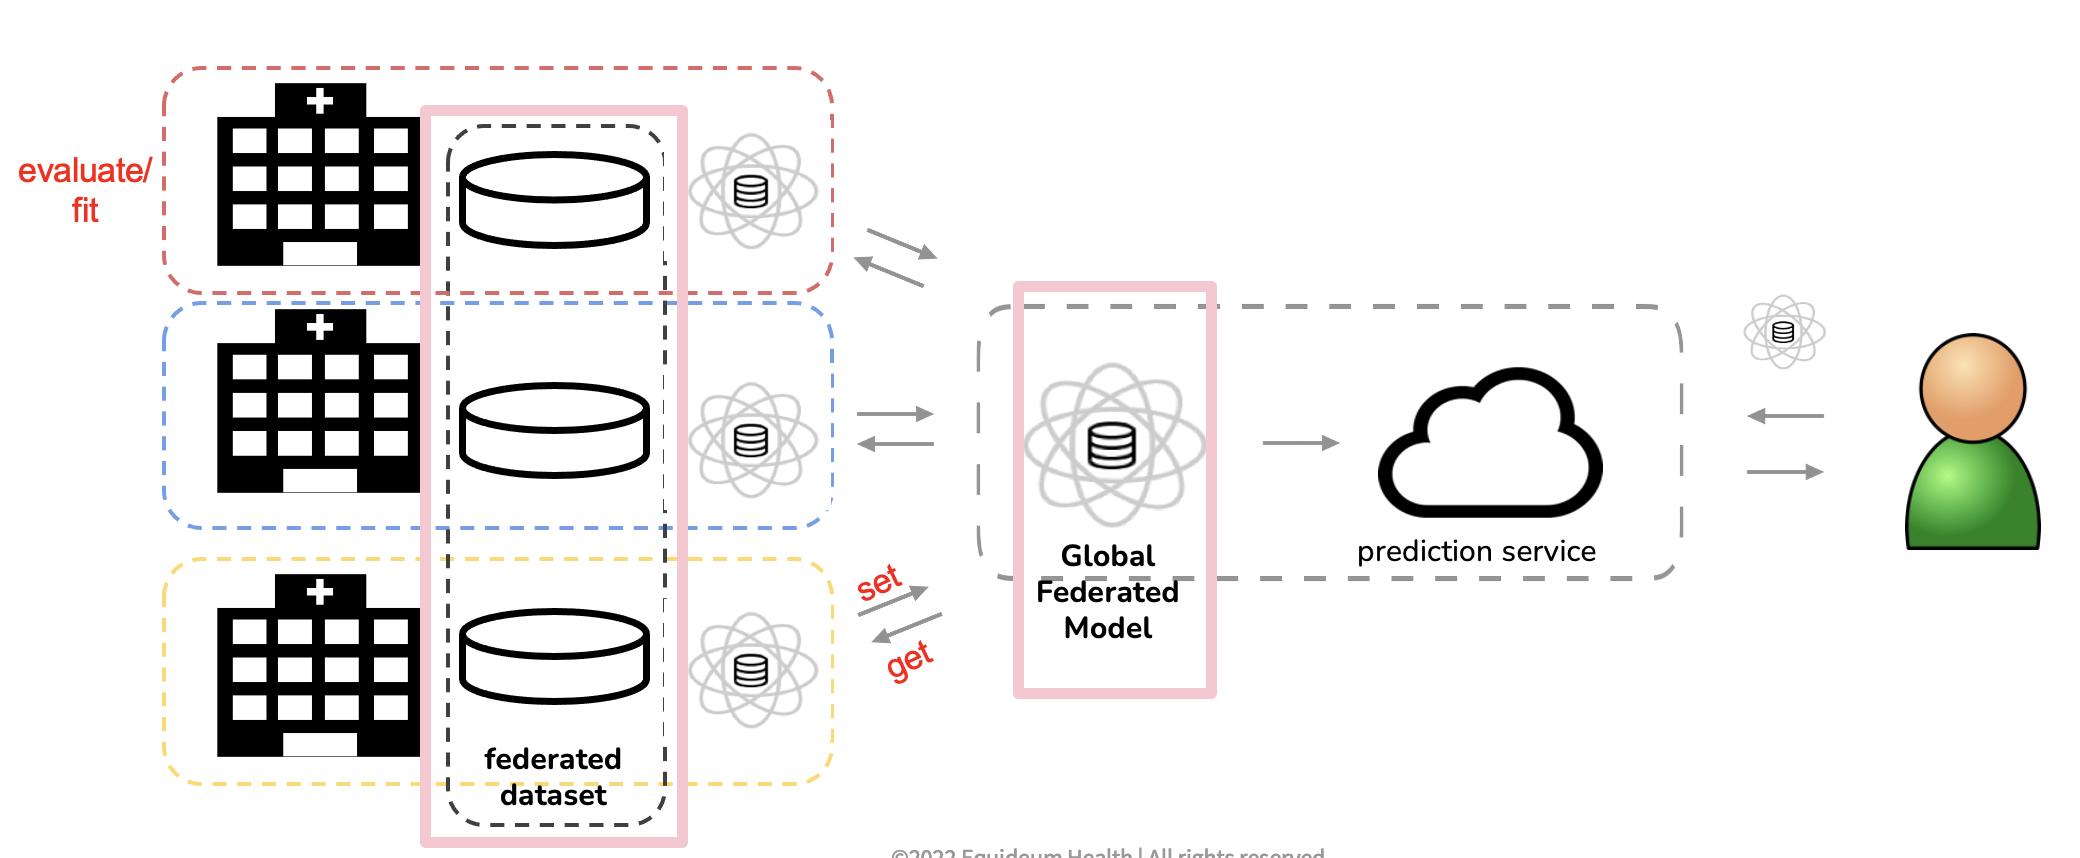

The local training/evaluation are defined in `FlowerClient`. It allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a single client. Thus for three clients, three instances of `FlowerClient` are called.


In [ ]:
class SimulatedFLClient(fl.client.NumPyClient):
    def __init__(self, cid: str, fed_dir_data: str, in_channels: int, data_str: str,
                 num_classes: int, criterion: torch.nn.Module, data_flag: str,):
        self.cid = cid
        self.fed_dir = Path(fed_dir_data)
        self.properties: Dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}
        self.data_flag = data_flag
        self.data_str = data_str

        # instantiate model
        self.net = Net(in_channels=in_channels, num_classes=num_classes)
        
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=0.001, 
                                         momentum=0.9)
        self.criterion = criterion

        # determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else 
                                   "cpu")

    def get_parameters(self):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def get_properties(self, ins):
        return self.properties

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in 
                                  params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):

        self.set_parameters(parameters)

        # load data for this client and get trainloader
        num_workers = len(ray.worker.get_resource_ids()["CPU"])
        trainloader = get_federated_dataloader(base_path=self.fed_dir,
                                               client_id=self.cid, data_str = self.data_str,
                                               is_train=True,
                                               batch_size=int(config["batch_size"]),
                                               workers=num_workers,
                                               shuffle=True,
                                               transforms=pathmnist_transforms(),)

        # send model to device
        self.net.to(self.device)

        # train
        train(model=self.net, optimizer=self.optimizer, criterion=self.criterion,
              train_loader=trainloader, NUM_EPOCHS=int(config["epochs"]),
              device=self.device,)

        # return local model and statistics
        return self.get_parameters(), len(trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"evaluate() on client cid={self.cid}")
        self.set_parameters(parameters)

        # load data for this client and get trainloader
        num_workers = (len(ray.worker.get_resource_ids()["CPU"]) if 
                       ray.is_initialized() else 1)

        valloader = get_federated_dataloader(base_path=self.fed_dir, client_id=self.cid, 
                                             data_str = self.data_str, is_train=False,
                                             batch_size=50, workers=num_workers,
                                             shuffle=False, 
                                             transforms=pathmnist_transforms(),)

        # send model to device
        self.net.to(self.device)

        # evaluate
        loss, accuracy, auc = test(model=self.net, criterion=self.criterion, 
                                   data_flag=self.data_flag, eval_loader=valloader,
                                   split="val", device=self.device,)

        # return statistics
        return (float(loss), len(valloader.dataset), {"accuracy": float(accuracy),
                                                      "auc": auc},)

### Calling a flower Client

Let us define the parameters to run the FL experiment with flower. With the 3 clients that we have chose each client will get allocated 1 CPU. For this example Cross Entropy is chosen as the loss function.

In [ ]:
num_client_cpus = 1
client_resources = {"num_cpus": num_client_cpus}
criterion = torch.nn.CrossEntropyLoss()
data_str = "pathmnist"

In [ ]:
def client_fn(cid: str):
        # create a single client instance
        return SimulatedFLClient(cid, fed_dir, in_channels=n_channels,
                                 data_str = data_str, num_classes=n_classes, 
                                 criterion=criterion, data_flag=trainset.flag,)

### Server-side Evaluation
Before we create a FL learning strategy we define a function that allows us to set the weights to enable centralized evaluation.

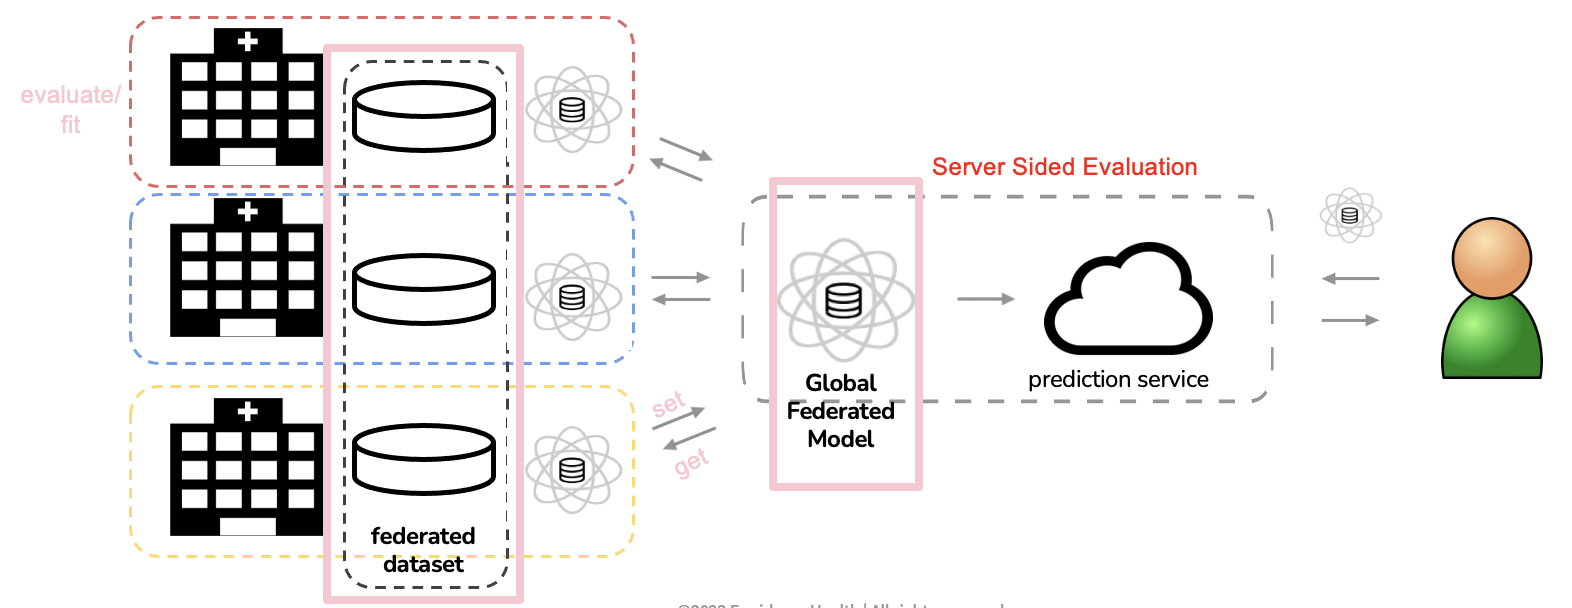

In [ ]:
def set_weights(model: torch.nn.ModuleList, weights: fl.common.Weights) -> None:
    """Set model weights from a list of NumPy ndarrays."""
    state_dict = OrderedDict({ k: torch.tensor(np.atleast_1d(v))
    for k, v in zip(model.state_dict().keys(), weights)})
    model.load_state_dict(state_dict, strict=True)

def centralised_eval_fn(testset: torch.utils.data.Dataset, criterion: torch.nn.Module,
                        in_channels: int, num_classes: int,) -> Callable[[fl.common.Weights], Optional[Tuple[float, float]]]:
    """Return an evaluation function for centralized evaluation."""

    def evaluate(weights: fl.common.Weights) -> Optional[Tuple[float, float]]:
        """Use the entire test set for evaluation."""

        # determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = Net(num_classes=num_classes, in_channels=in_channels)
        set_weights(model, weights)
        model.to(device)

        testloader = torch.utils.data.DataLoader(testset, batch_size=50)
        loss, accuracy, auc = test(model=model, criterion=criterion, 
                                   data_flag=testset.flag, eval_loader=testloader, 
                                   split="test", device=device,)

        # return statistics
        return loss, {"accuracy": accuracy, "auc": auc}

    return evaluate

### Experiment 2
We are now defining a configuration.

In [ ]:
local_epochs = str(2)

In [ ]:
def fit_config(rnd: int) -> Dict[str, str]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {"epoch_global": str(rnd), "epochs": local_epochs,  # number of local epochs
              "batch_size": str(128),}
    return config 

### Creating a Federated Learning Strategy

Flower allows us to use implementations to customize nearly all aspects of the federated learning approach. We have chosen `FedAvg` implementation. We can customize it using a few basic parameters.

In [ ]:
strategy = fl.server.strategy.FedAvg(fraction_fit=1.0, min_fit_clients=2,
                                     min_available_clients=pool_size,  
                                     on_fit_config_fn=fit_config,
                                     eval_fn=centralised_eval_fn(testset, 
                                                                 criterion=criterion, 
                                                                 in_channels=n_channels, 
                                                                 num_classes=n_classes,
                                                                 )# centralised testset evaluation of global model
                                     ,)

# (optional) specify ray config, set local_mode to true for serial debugging
ray_config = {"include_dashboard": False, "local_mode": False}

### Experiment 3

Flower has multiple build in strategies available. Please refer here [link text](https://flower.dev/docs/apiref-flwr.html#module-flwr.server.strategy). How about we test another one?

### Starting the training
Now we have a `SimulatedFLClient` which defines client-side training and evaluation and defined a strategy. Thus, we are ready to start the simulation through `start_simulation`. This accepts the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm

In [ ]:
num_rounds = 2

In [ ]:
fl.simulation.start_simulation(client_fn=client_fn, num_clients=pool_size,
                               client_resources=client_resources,
                               num_rounds= num_rounds, strategy=strategy,
                               ray_init_args=ray_config,)

INFO flower 2022-07-13 16:48:03,521 | app.py:158 | Ray initialized with resources: {'node:172.28.0.2': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0, 'object_store_memory': 3930134937.0, 'memory': 7860269876.0}
INFO flower 2022-07-13 16:48:03,527 | app.py:174 | Starting Flower simulation running: Config(num_rounds=2, round_timeout=None)
INFO flower 2022-07-13 16:48:03,532 | server.py:84 | Initializing global parameters
INFO flower 2022-07-13 16:48:03,535 | server.py:256 | Requesting initial parameters from one random client
INFO flower 2022-07-13 16:48:05,165 | server.py:259 | Received initial parameters from one random client
INFO flower 2022-07-13 16:48:05,167 | server.py:86 | Evaluating initial parameters
INFO flower 2022-07-13 16:48:17,989 | server.py:93 | initial parameters (loss, other metrics): 317.10838651657104, {'accuracy': 0.1032033426183844, 'auc': 0.5992322896473882}
INFO flower 2022-07-13 16:48:17,996 | server.py:99 | FL starting
DEBUG flower 2022-07-13 16:48:17

test  auc: 0.599  acc:0.103


100%|█████████▉| 316/317 [01:50<00:00,  3.74it/s]
DEBUG flower 2022-07-13 16:51:55,037 | server.py:220 | fit_round received 2 results and 0 failures
WARNING flower 2022-07-13 16:51:55,072 | fedavg.py:237 | No fit_metrics_aggregation_fn provided
100%|██████████| 317/317 [01:50<00:00,  2.88it/s]
INFO flower 2022-07-13 16:51:56,773 | server.py:120 | fit progress: (1, 112.50225314497948, {'accuracy': 0.7532033426183844, 'auc': 0.9485761674350722}, 218.7762292020002)
DEBUG flower 2022-07-13 16:51:56,775 | server.py:161 | evaluate_round: strategy sampled 2 clients (out of 2)


test  auc: 0.949  acc:0.753
(launch_and_evaluate pid=761) evaluate() on client cid=0
(launch_and_evaluate pid=760) evaluate() on client cid=1


DEBUG flower 2022-07-13 16:52:02,053 | server.py:174 | evaluate_round received 2 results and 0 failures
WARNING flower 2022-07-13 16:52:02,055 | fedavg.py:268 | No evaluate_metrics_aggregation_fn provided
DEBUG flower 2022-07-13 16:52:02,061 | server.py:207 | fit_round: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=760) val  auc: 0.963  acc:0.748
(launch_and_evaluate pid=761) val  auc: 0.966  acc:0.747


100%|█████████▉| 316/317 [01:53<00:00,  3.85it/s]
DEBUG flower 2022-07-13 16:55:45,077 | server.py:220 | fit_round received 2 results and 0 failures
100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
INFO flower 2022-07-13 16:55:46,922 | server.py:120 | fit progress: (2, 108.17722100019455, {'accuracy': 0.784958217270195, 'auc': 0.9615741170861567}, 448.9250682730001)
DEBUG flower 2022-07-13 16:55:46,928 | server.py:161 | evaluate_round: strategy sampled 2 clients (out of 2)


test  auc: 0.962  acc:0.785
(launch_and_evaluate pid=761) evaluate() on client cid=0
(launch_and_evaluate pid=760) evaluate() on client cid=1


DEBUG flower 2022-07-13 16:55:52,648 | server.py:174 | evaluate_round received 2 results and 0 failures
INFO flower 2022-07-13 16:55:52,650 | server.py:138 | FL finished in 454.6529726350002
INFO flower 2022-07-13 16:55:52,654 | app.py:178 | app_fit: losses_distributed [(1, 63.04856324195862), (2, 48.78653750568628)]
INFO flower 2022-07-13 16:55:52,657 | app.py:179 | app_fit: metrics_distributed {}
INFO flower 2022-07-13 16:55:52,658 | app.py:180 | app_fit: losses_centralized [(0, 317.10838651657104), (1, 112.50225314497948), (2, 108.17722100019455)]
INFO flower 2022-07-13 16:55:52,660 | app.py:181 | app_fit: metrics_centralized {'accuracy': [(0, 0.1032033426183844), (1, 0.7532033426183844), (2, 0.784958217270195)], 'auc': [(0, 0.5992322896473882), (1, 0.9485761674350722), (2, 0.9615741170861567)]}


History (loss, distributed):
	round 1: 63.04856324195862
	round 2: 48.78653750568628
History (loss, centralized):
	round 0: 317.10838651657104
	round 1: 112.50225314497948
	round 2: 108.17722100019455
History (metrics, centralized):
{'accuracy': [(0, 0.1032033426183844), (1, 0.7532033426183844), (2, 0.784958217270195)], 'auc': [(0, 0.5992322896473882), (1, 0.9485761674350722), (2, 0.9615741170861567)]}

### Hands-On


When chosing a high alpha we run:
1. Simple FedAVg with IID data


However, what if we change the alpha parameter. Please go back to Experiment 1 and re-run the code and adjust alpha to a lower value.
2. Same FedAvg but non-IID split 


Now what happens when we increase the number of local iterantions? Please reset alpha back to 1000 and go back to Experiment 2 and re-run the code
3. Play with number of local iterations


Reset the other parameters. Please go to Experiment 3
4. Test other aggregation strategies to address the non-IID setting


# References


*   MedMNIST code adapted from this Getting Started example.
*   Flower code adapted from this example: https://github.com/adap/flower/tree/2d45f12189984c2901d54e295f5c684b07039bd8/examples/simulation_pytorch
*   Structure from https://colab.research.google.com/github/adap/flower/blob/main/tutorials/Flower-1-Intro-to-FL-PyTorch.ipynb#scrollTo=J4Em7BPNTXeX